# Project - Testing Normality of Stock Market Returns

In this chapter, we examine the daily return of Microsoft's stock to determine if it follows a normal distribution.

### Getting Microsoft stock price data

Twenty years of Microsoft stock price data is stored in the msft20.csv file in the stocks directory. Let's read this in setting the `date` as the index.

In [1]:
import pandas as pd
msft = pd.read_csv('../data/stocks/msft20.csv', 
                   parse_dates=['date'], index_col='date')
msft.head()

,open,high,low,close,adjusted_close,volume,dividend_amount
date,,,,,,,
1999-10-19,88.250,89.250,85.250,86.313,27.8594,69945600,0.0
1999-10-20,91.563,92.375,90.250,92.250,29.7758,88090600,0.0
1999-10-21,90.563,93.125,90.500,93.063,30.0381,60801200,0.0
1999-10-22,93.563,93.875,91.750,92.688,29.9171,43650600,0.0
1999-10-25,92.000,93.563,91.125,92.438,29.8364,30492200,0.0


### Select the closing price

For this problem, we are only interested in the closing price. Select the `adjusted_close` as this is adjusted for any stock splits that may have occurred.

In [2]:
close = msft['adjusted_close']
close.head(3)

date
1999-10-19    27.8594
1999-10-20    29.7758
1999-10-21    30.0381
Name: adjusted_close, dtype: float64

### Daily percent change

pandas Series have a method called `pct_change`, which returns the percentage difference between the current and previous elements. Let's use it to calculate the daily return.

In [3]:
close_change = close.pct_change()
close_change.head(3)

date
1999-10-19         NaN
1999-10-20    0.068788
1999-10-21    0.008809
Name: adjusted_close, dtype: float64

### Handling Missing Value

The first date has a missing value since there was no previous date. The `dropna` method can be used to remove any `NaN` elements.

In [10]:
close_change = close_change.dropna()
close_change.head(3)

date
1999-10-20    0.068788
1999-10-21    0.008809
1999-10-22   -0.004028
Name: adjusted_close, dtype: float64

### Checking for Normality

There are formal statistical tests for normality that can be used. Instead we will focus on simple data exploration to give us insight.

### Plotting the returns

The main plotting library in Python is matplotlib which will be covered in greater detail in the **Visualization with Matplotlib** part. pandas objects have hooks into matplotlib so it's not necessary to import matplotlib directly, but we do so here to use our stylesheet for the book. The `plot` method can be used to create a number of different kinds of plots with the `kind` parameter. We pass it the string `hist` to create a histogram, along with a histogram-specific argument, `bins`, to control the number of bars plotted.

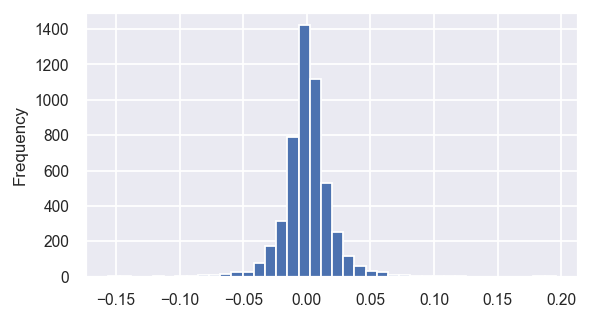

In [11]:
import seaborn as sns
sns.set_theme(rc={'figure.figsize': (5, 2.7), 'figure.dpi': 127}, 
              font_scale=0.8)
close_change.plot(kind='hist', bins=40);

### Use boolean selection to check for normality

The plot above is symmetrical and somewhat bell-shaped. It could possibly represent a normal distribution. To more formally check for normality, we can count the number of observations that are within 1, 2, and 3 standard deviations. The [68-95-99.7 rule][1] can be used to determine if the data is approximately normal. We first need to calculate the mean and standard deviation.

[1]: https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule

In [12]:
mean = close_change.mean()
std = close_change.std()
mean, std

(np.float64(0.0005010304494320831), np.float64(0.019119644436205206))

### Absolute number of standard deviations from the mean

To standardize our results, we can find the number of standard deviations away from the mean each daily return is. To do this, we subtract the mean from the entire Series and then divide by the standard deviation. This quantity is referred to as the **z-score**.

In [13]:
z_score = (close_change - mean) / std

z_score

date
1999-10-20    3.571575
1999-10-21    0.434534
1999-10-22   -0.236890
1999-10-25   -0.167288
1999-10-26   -0.061615
                ...   
2019-10-15    0.730875
2019-10-16   -0.454760
2019-10-17   -0.294402
2019-10-18   -0.879874
2019-10-21    0.346811
Name: adjusted_close, Length: 5033, dtype: float64

To help make calculations easier, we will use the absolute value of the z-score.

In [14]:
z_score_abs = z_score.abs()

### Find the percentage by taking the mean

Let's find the percentage of returns within 1, 2, and 3 standard deviations by taking the mean of a boolean Series.

In [15]:
pct_within1 = round((z_score_abs < 1).mean(), 3)
pct_within2 = round((z_score_abs < 2).mean(), 3)
pct_within3 = round((z_score_abs < 3).mean(), 3)
pct_within1, pct_within2, pct_within3

(np.float64(0.793), np.float64(0.951), np.float64(0.983))

## Results discussion

The percentages of returns within 1, 2 and 3 standard deviations are fairly different than the 68-95-99.7 rule. Much more of the data was concentrated within 1 standard deviation. A much greater percentage of the returns were greater than 3 standard deviations from the mean compared to just 0.3% for the rule. This strongly suggests that a normal distribution would not be a good fit for this type of data.

### Using the percentile to check for normality

Alternatively, we can work backwards and find the z-score that represents the 68th, 95th, and 99.7th percentiles of the distribution. For normally distributed data, we would expect these to be 1, 2, and 3 respectively. The `quantile` method completes this operation for us. Note how far off the 68th and 99.7th percentiles are.

In [16]:
z_score_abs.quantile([.68, .95, .997]).round(2)

0.680    0.71
0.950    1.98
0.997    5.16
Name: adjusted_close, dtype: float64

### Check that all Series values are `True`

Let's say we wanted to check if all the stock price returns were within 4 standard deviations from the mean. For boolean Series, the `all` method returns `True` if all values are `True`, and `False` otherwise.

In [11]:
criteria = z_score_abs < 4
criteria.head(3)

date
1999-10-20    True
1999-10-21    True
1999-10-22    True
Name: adjusted_close, dtype: bool

In [12]:
criteria.all()

False

We can duplicate the above logic with the `any` method. The `any` method returns `True` if one or more values in the Series are `True`. Here, we check if any of the returns are greater than or equal to 4.

In [13]:
criteria = z_score_abs >= 4
criteria.any()

True

## Exercises

Execute the cells below to read in 20 years of Apple (AAPL) data as a Series and answer the exercises below with it.

In [17]:
stocks = pd.read_csv('../data/stocks/stocks10.csv', index_col='date',
                     parse_dates=['date'])
stocks.head(3)

,MSFT,AAPL,SLB,AMZN,TSLA,XOM,WMT,T,FB,V
date,,,,,,,,,,
1999-10-25,29.84,2.32,17.02,82.75,NaN,21.45,38.99,16.78,NaN,NaN
1999-10-26,29.82,2.34,16.65,81.25,NaN,20.89,37.11,17.28,NaN,NaN
1999-10-27,29.33,2.38,16.52,75.94,NaN,20.80,36.94,18.27,NaN,NaN


In [31]:
aapl = stocks['AAPL']
aapl.head()

date
1999-10-25    2.32
1999-10-26    2.34
1999-10-27    2.38
1999-10-28    2.43
1999-10-29    2.50
Name: AAPL, dtype: float64

### Exercise 1

<span  style="color:green; font-size:16px">Use one line of code to find the daily percentage returns of AAPL and drop any missing values. Save the result to `aapl_change`.</span>

In [21]:
aapl_change = aapl.pct_change().dropna()

### Exercise 2

<span style="color:green; font-size:16px">Find the mean daily return for Apple, the first and last closing prices, and the number of trading days. Store all four of these values into separate variables.</span>

In [ ]:
mean_return = aapl_change.mean()

first_closing = aapl.iloc[0]

last_closing = aapl.iloc[-1]

num_trading_days = len(aapl)



np.float64(0.0012692984527780723)

### Exercise 3

<span style="color:green; font-size:16px">If Apple returned its mean percentage return every single day since the first day you have data, what would its last closing price be? Is it the same as the actual last closing price? You need to use all the variables calculated from Exercise 2.</span>

In [39]:
projected_growth = (1 + mean_return) ** num_trading_days

proj_final_closing = projected_growth * first_closing

proj_final_closing

np.float64(1374.5687797657017)

### Exercise 4

<span  style="color:green; font-size:16px">Find the z-score for the Apple daily returns. Save this to a variable `z_score_raw`. What is the max and minimum score?</span>

In [42]:
mean = aapl_change.mean()
std = aapl_change.std()

z_score_raw = (aapl_change - mean) / std

z_score_raw

date
1999-10-26    0.286300
1999-10-27    0.616294
1999-10-28    0.768740
1999-10-29    1.072441
1999-11-01   -1.295674
                ...   
2019-10-18    0.137612
2019-10-21    0.625981
2019-10-22   -0.138493
2019-10-23    0.473167
2019-10-24   -0.164740
Name: AAPL, Length: 5032, dtype: float64

### Exercise 5

<span  style="color:green; font-size:16px">What percentage did Apple's stock increase when it had its highest maximum raw z-score?</span>

In [60]:
z_score_raw.max()

np.float64(5.3712520859138)

In [70]:
idx = z_score_raw.idxmax()

aapl_change.loc[idx]

np.float64(0.13918806959403485)

In [61]:
z_score_raw.agg(['max','idxmax'])

max                  5.371252
idxmax    2008-10-13 00:00:00
Name: AAPL, dtype: object

### Exercise 6

<span style="color:green; font-size:16px">Create a function that accepts a Series of stock closing prices. Have it return the percentage of prices within 1, 2, and 3 standard deviations from the mean. Use your function to return results for different stocks found in the `stocks` DataFrame.</span>

In [52]:
stocks.head(3)

,MSFT,AAPL,SLB,AMZN,TSLA,XOM,WMT,T,FB,V
date,,,,,,,,,,
1999-10-25,29.84,2.32,17.02,82.75,NaN,21.45,38.99,16.78,NaN,NaN
1999-10-26,29.82,2.34,16.65,81.25,NaN,20.89,37.11,17.28,NaN,NaN
1999-10-27,29.33,2.38,16.52,75.94,NaN,20.80,36.94,18.27,NaN,NaN


In [75]:
def get_pct_std(ticker:str):
    stock_ser = stocks[ticker]

    stock_pct_chng = stock_ser.pct_change().dropna()

    stock_mean = stock_pct_chng.mean()

    stock_std = stock_pct_chng.std()

    z_score_raw = (stock_pct_chng - stock_mean) / stock_std

    z_score_abs = z_score_raw.abs()

    pct_within1 = round((z_score_abs < 1).mean(), 3)
    pct_within2 = round((z_score_abs < 2).mean(), 3)
    pct_within3 = round((z_score_abs < 3).mean(), 3)
    
    return pct_within1, pct_within2, pct_within3

get_pct_std('MSFT')

(np.float64(0.793), np.float64(0.951), np.float64(0.983))

### Exercise 7

<span  style="color:green; font-size:16px"> How many days did Apple close above 100 and below 120?</span>

In [80]:
aapl[(aapl > 100) & (aapl < 120)].count()

np.int64(401)

In [82]:
aapl.between(100,120,inclusive='neither').sum()

np.int64(401)

### Exercise 8

<span style="color:green; font-size:16px"> How many days did Apple close below 50 or above 150?</span>

In [84]:
((aapl < 50) | (aapl > 150)).sum()

np.int64(3596)

### Exercise 9

<span  style="color:green; font-size:16px"> Look up the definition for interquartile range and select all Apple closing prices that are within this range. There are multiple ways to do this. Check the `quantile` method.</span>

In [86]:
first, third = aapl.quantile([0.25,0.75])

In [88]:
aapl.between(first,third).sum()

np.int64(2518)

### Exercise 10

<span style="color:green; font-size:16px">Find the date of the highest closing price. Find out how many trading days it has been since Apple recorded it highest closing price.</span>

In [102]:
highest_close_price = aapl.nlargest(1)

max_close_date = aapl.idxmax()

aapl.index.max() - max_close_date


Timedelta('1 days 00:00:00')